In [1]:
import gzip
import pickle
import struct
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
from array import array as pyarray
from scipy.ndimage import interpolation
from sklearn import svm, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV



In [2]:

samplesSize = 10000
testSize = [500, 1000, 3000, 10000]
digits = np.arange(10)


def moments(image):
	"""
	https://fsix.github.io/mnist/Deskewing.html
	:param image:
	:return:
	"""
	c0, c1 = np.mgrid[:image.shape[0], :image.shape[1]]  # A trick in numPy to create a mesh grid
	totalImage = np.sum(image)  # sum of pixels
	m0 = np.sum(c0 * image) / totalImage  # mu_x
	m1 = np.sum(c1 * image) / totalImage  # mu_y
	m00 = np.sum((c0 - m0) ** 2 * image) / totalImage  # var(x)
	m11 = np.sum((c1 - m1) ** 2 * image) / totalImage  # var(y)
	m01 = np.sum((c0 - m0) * (c1 - m1) * image) / totalImage  # covariance(x,y)
	mu_vector = np.array([m0, m1])  # Notice that these are \mu_x, \mu_y respectively
	covariance_matrix = np.array([[m00, m01], [m01, m11]])  # Do you see a similarity between the covariance matrix
	return mu_vector, covariance_matrix


def deskew(image):
	"""
	https://fsix.github.io/mnist/Deskewing.html
	:param image:
	:return:
	"""
	c, v = moments(image)
	alpha = v[0, 1] / v[0, 0]
	affine = np.array([[1, 0], [alpha, 1]])
	ocenter = np.array(image.shape) / 2.0
	offset = c - np.dot(affine, ocenter)
	return interpolation.affine_transform(image, affine, offset=offset)


def loadMNIST(imagePath, labelPath, size=1000, digits=np.arange(10)):
	"""

	:param imagePath:
	:param labelPath:
	:param size:
	:param digits:
	:return:
	"""
	N = size

	with gzip.open(labelPath, 'rb') as finf:
		magic_nr, size = struct.unpack(">II", finf.read(8))
		lbl = pyarray("b", finf.read())

		ind = [k for k in range(size) if lbl[k] in digits]
		labels = np.zeros((N, 1), dtype=np.int8)
		for i in range(N):
			labels[i] = lbl[ind[i]]
		finf.close()

	with gzip.open(imagePath, 'rb') as fimg:
		magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
		img = pyarray("B", fimg.read())

		ind = [k for k in range(size) if lbl[k] in digits]
		images = np.zeros((N, rows * cols), dtype=np.float)

		for i in range(N):  # int(len(ind) * size/100.)):
			images[i] = np.array(img[ind[i] * rows * cols: (ind[i] + 1) * rows * cols]) \
				            .reshape((rows * cols)) / 255.0

		fimg.close()

	labels = [label[0] for label in labels]
	return images, labels


In [3]:


MNISTImgTrain = "datasets/train-images-idx3-ubyte.gz"
MNISTLabelTrain = "datasets/train-labels-idx1-ubyte.gz"
MNISTImg = "datasets/t10k-images-idx3-ubyte.gz"
MNISTLabel = "datasets/t10k-labels-idx1-ubyte.gz"

# Test if the images are loaded correctly!
train_img, train_lbl = loadMNIST(MNISTImgTrain, MNISTLabelTrain, 5)


/tmp/ipykernel_124980/674511414.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = np.zeros((N, rows * cols), dtype=np.float)


/tmp/ipykernel_124980/674511414.py:35: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image, affine, offset=offset)


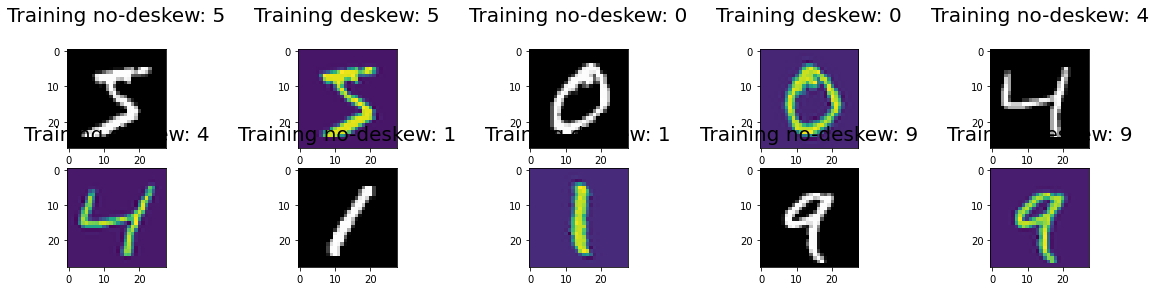

In [4]:

plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
	plt.subplot(2, 5, 2 * index + 1)
	plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
	plt.title('Training no-deskew: {}\n'.format(label), fontsize=20)
	plt.subplot(2, 5, 2 * index + 2)
	plt.imshow(deskew(image.reshape(28, 28)).reshape(28, 28))
	plt.title('Training deskew: {}\n'.format(label), fontsize=20)
plt.show()

#

In [5]:
# 2 Regression model Logistic
bestModels = []
bestPredict = []

# parameters = {'C': [0.001, 0.1, 1, 0.25, 0.5, 0.75, 100, 10e5], 'gamma': [10, 1, 0.1, 0.01, 'auto']}
# 'kernel': ['rbf', 'poly'], 'shrinking': (True, False)}#'degree': [3, 9],
#              'decision_function_shape': ['ovr', 'ovo']}

parameters = {'kernel': ['rbf', 'poly'], 'C': [0.1, 0.5, 1.0, 1.5], 'degree': [2, 3, 4, 5],
              'gamma': [0.001, 0.01, 0.1, 0.5]}

# Load datasets and skew the data.
X, y = loadMNIST(MNISTImgTrain, MNISTLabelTrain, samplesSize)
Xskew = np.array([deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in X])

# Remove features that does little to no contribution on the data.
variance = 0.005
print("Original datashape", Xskew.shape)
var = VarianceThreshold(variance)
XskewReVariance = var.fit_transform(Xskew)


/tmp/ipykernel_124980/674511414.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = np.zeros((N, rows * cols), dtype=np.float)
/tmp/ipykernel_124980/674511414.py:35: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image, affine, offset=offset)


Original datashape (10000, 784)


In [6]:

# Save the model.
pickleTransformPath = "exec3_transform.sav"
with open(pickleTransformPath, 'wb') as f:
	pickle.dump(var, f)
print("Shape with variance higher than {}".format(variance), XskewReVariance.shape)

# Process the features values.
scaler = preprocessing.StandardScaler()
nX = scaler.fit_transform(XskewReVariance)
print("scalar mean", scaler.mean_)

for t in testSize:
	tX, ty = loadMNIST(MNISTImg, MNISTLabel, t)
	tXSkewed = np.array([deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in tX])

	print("Test data original shape ", tXSkewed.shape)
	tXSkewedVar = var.transform(tXSkewed)
	ntX = scaler.transform(tXSkewedVar)
	print("Test data transformed shape ", tXSkewedVar.shape)

	n_iters = 20
	for _k in [5, 10]:
		grid = RandomizedSearchCV(estimator=svm.SVC(verbose=False), param_distributions=parameters, n_jobs=-1, cv=_k,
		                          n_iter=n_iters)
		grid.fit(nX, y)
		score = grid.best_score_
		model = grid.best_estimator_
		predictScore = grid.score(ntX, ty)
		print("k: {} estimator score ".format(_k), score)
		print("k: {} predict score ".format(_k), predictScore)
		print(model)

		bestModels.append([score, model])
		bestPredict.append(predictScore)

sortedModel = sorted(bestModels, key=itemgetter(0))
bestScore, bestModel = sortedModel[-1]
print("Best estimator score", bestScore)
print("Best predict score", sorted(bestPredict)[-1])
print("Best model\n", bestModel)
modelPath = "exec3_model.sav"
with open(modelPath, 'wb') as f:
	pickle.dump(bestModel, f)

Shape with variance higher than 0.005 (10000, 418)
scalar mean [0.01140436 0.02422873 0.02969002 0.01948617 0.00802881 0.01353067
 0.01979042 0.02599208 0.03258619 0.0526374  0.07522464 0.07025678
 0.04504014 0.02026095 0.01738485 0.03475568 0.05849459 0.0926642
 0.14581201 0.21952041 0.26730919 0.2389541  0.16723772 0.09514661
 0.04727986 0.02249375 0.01005093 0.02108476 0.04991082 0.09036696
 0.14881539 0.22180942 0.31635883 0.44107702 0.51025729 0.4571429
 0.34360354 0.22895709 0.13428726 0.07188626 0.03665528 0.01890709
 0.01534563 0.04327955 0.093602   0.17099003 0.26908155 0.36092779
 0.45346332 0.5621677  0.60857142 0.57606917 0.48497815 0.39143784
 0.27058952 0.15022176 0.07627167 0.03824881 0.01869371 0.00970855
 0.02917055 0.07218287 0.14991885 0.26372694 0.38102317 0.47012147
 0.53790264 0.59898646 0.60414552 0.57292187 0.53680789 0.50680483
 0.4142762  0.26377372 0.13443701 0.06239922 0.02961691 0.01211712
 0.01737175 0.04648572 0.10474126 0.20683747 0.34662131 0.46953577
 

/tmp/ipykernel_124980/674511414.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = np.zeros((N, rows * cols), dtype=np.float)
/tmp/ipykernel_124980/674511414.py:35: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image, affine, offset=offset)


KeyboardInterrupt: 